# Imports and Dependancies

In [147]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import chi2_contingency

In [148]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading and Cleaning Data

## Initial  Extraction

In [149]:
combined_path = "/content/drive/MyDrive/combined.csv"
action_data_path = "/content/drive/MyDrive/action_bias_data.csv"
bias_data = pd.read_csv(combined_path)
bias_data_copy = pd.read_csv(combined_path)
action_data = pd.read_csv(action_data_path)

In [150]:
bias_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   action        10075 non-null  object
 1   sample        10075 non-null  int64 
 2   imgPath       10075 non-null  object
 3   vidPath       10075 non-null  object
 4   dataset       10075 non-null  object
 5   response      10000 non-null  object
 6   one_person    10075 non-null  object
 7   face_visible  10075 non-null  object
 8   gender        10075 non-null  object
 9   age           10075 non-null  object
 10  race          10075 non-null  object
dtypes: int64(1), object(10)
memory usage: 865.9+ KB


## Cleaning and Filtering

In [151]:
print(bias_data['gender'].value_counts())
print(bias_data['age'].value_counts())
print(bias_data['race'].value_counts())

gender
male      5012
female    3403
ERROR     1658
other        2
Name: count, dtype: int64
age
adult          4666
teenager       2371
ERROR          1664
middle-aged     716
child           553
senior          105
Name: count, dtype: int64
race
white              5929
ERROR              1657
indian              852
east asian          840
black               345
southeast asian     223
latino              134
middle eastern       95
Name: count, dtype: int64


In [152]:
bias_data = bias_data[~(bias_data == 'ERROR').any(axis = 1)]          # remove any samples that have an error value
bias_data_copy = bias_data_copy[~(bias_data_copy == 'ERROR').any(axis = 1)]          # remove any samples that have an error value

In [153]:
print(len(bias_data["action"].unique()))
bias_data.info()

500
<class 'pandas.core.frame.DataFrame'>
Index: 8366 entries, 0 to 10074
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   action        8366 non-null   object
 1   sample        8366 non-null   int64 
 2   imgPath       8366 non-null   object
 3   vidPath       8366 non-null   object
 4   dataset       8366 non-null   object
 5   response      8291 non-null   object
 6   one_person    8366 non-null   object
 7   face_visible  8366 non-null   object
 8   gender        8366 non-null   object
 9   age           8366 non-null   object
 10  race          8366 non-null   object
dtypes: int64(1), object(10)
memory usage: 784.3+ KB


In [154]:
bias_data = bias_data[bias_data['one_person'] == "yes"]               # remove samples with more than one person

In [155]:
print(len(bias_data["action"].unique()))
bias_data.info()

499
<class 'pandas.core.frame.DataFrame'>
Index: 7124 entries, 0 to 10074
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   action        7124 non-null   object
 1   sample        7124 non-null   int64 
 2   imgPath       7124 non-null   object
 3   vidPath       7124 non-null   object
 4   dataset       7124 non-null   object
 5   response      7049 non-null   object
 6   one_person    7124 non-null   object
 7   face_visible  7124 non-null   object
 8   gender        7124 non-null   object
 9   age           7124 non-null   object
 10  race          7124 non-null   object
dtypes: int64(1), object(10)
memory usage: 667.9+ KB


In [156]:
bias_data = bias_data[bias_data['face_visible'] == "visible"]         # remove samples without face visible

In [157]:
print(len(bias_data["action"].unique()))
bias_data.info()

497
<class 'pandas.core.frame.DataFrame'>
Index: 6058 entries, 0 to 10074
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   action        6058 non-null   object
 1   sample        6058 non-null   int64 
 2   imgPath       6058 non-null   object
 3   vidPath       6058 non-null   object
 4   dataset       6058 non-null   object
 5   response      5983 non-null   object
 6   one_person    6058 non-null   object
 7   face_visible  6058 non-null   object
 8   gender        6058 non-null   object
 9   age           6058 non-null   object
 10  race          6058 non-null   object
dtypes: int64(1), object(10)
memory usage: 567.9+ KB


In [158]:
def UnderSample(data, bias_category):
    # goes -> actions -> category options and then samples based on the max allowed ammount
    # random state is needed to make sure the samples values are the same
    undersampled_data = (data.groupby('action', group_keys=False)
                        .apply(lambda action: action.groupby(bias_category, group_keys=False)
                        .apply(lambda category: category.sample(n = int(min(len(category), len(action) * .15)), random_state=6412)))
                        .reset_index(drop=True))
    return undersampled_data

In [159]:
# one hot encode
#bias_data['one_hot'] = bias_data['gender'] + '_' + bias_data['age'] + '_' + bias_data['race']

# one hot encoding
one_hot = pd.get_dummies(bias_data[['gender', 'age', 'race']], dtype=int)

# save values
bias_data['one_hot'] = one_hot.astype(str).agg(','.join, axis=1)

# undersample on one hot encoding
bias_data = UnderSample(bias_data, 'one_hot')

<ipython-input-158-9bfb9c3d0141>:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-158-9bfb9c3d0141>:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-158-9bfb9c3d0141>:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass

In [160]:
print(len(bias_data["action"].unique()))
bias_data.info()

418
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3558 entries, 0 to 3557
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   action        3558 non-null   object
 1   sample        3558 non-null   int64 
 2   imgPath       3558 non-null   object
 3   vidPath       3558 non-null   object
 4   dataset       3558 non-null   object
 5   response      3496 non-null   object
 6   one_person    3558 non-null   object
 7   face_visible  3558 non-null   object
 8   gender        3558 non-null   object
 9   age           3558 non-null   object
 10  race          3558 non-null   object
 11  one_hot       3558 non-null   object
dtypes: int64(1), object(11)
memory usage: 333.7+ KB


In [161]:
bias_data = bias_data.groupby('action').filter(lambda x: len(x) > 10) # remove actions that have lost the majority of samples

In [162]:
print(len(bias_data["action"].unique()))
bias_data.info()

122
<class 'pandas.core.frame.DataFrame'>
Index: 1616 entries, 3 to 3550
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   action        1616 non-null   object
 1   sample        1616 non-null   int64 
 2   imgPath       1616 non-null   object
 3   vidPath       1616 non-null   object
 4   dataset       1616 non-null   object
 5   response      1565 non-null   object
 6   one_person    1616 non-null   object
 7   face_visible  1616 non-null   object
 8   gender        1616 non-null   object
 9   age           1616 non-null   object
 10  race          1616 non-null   object
 11  one_hot       1616 non-null   object
dtypes: int64(1), object(11)
memory usage: 164.1+ KB


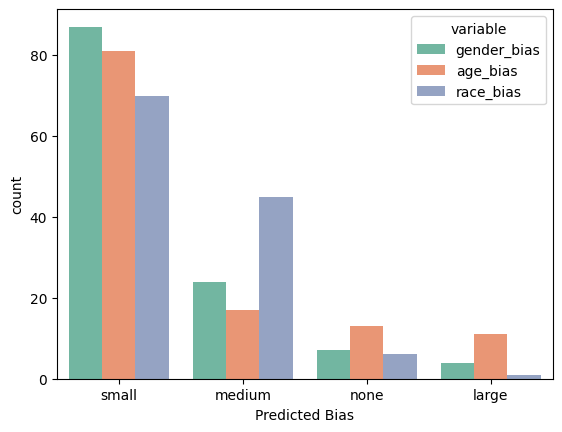

In [163]:
filtered_action_data = action_data[action_data["action"].isin(bias_data["action"].unique())]
data_filtered = filtered_action_data.drop(columns=['action', 'reasoning'])
melted = data_filtered.melt(value_vars=data_filtered.columns)
sns.countplot(data = melted, x='value', hue = 'variable', palette='Set2', order = melted['value'].value_counts().index)

#plt.title('GPT4 Bias Prediction for Actions in HAA500-B')
plt.xlabel('Predicted Bias')
plt.ylabel('count')
plt.show()

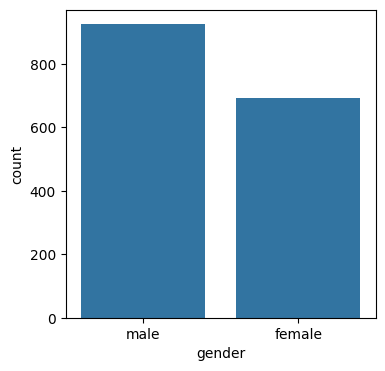

In [164]:
plt.figure(figsize=(4, 4))
sns.countplot(x='gender', data=bias_data, order=bias_data['gender'].value_counts().index)
#plt.title('HAA500-B Class Distribution (Gender)')
plt.show()

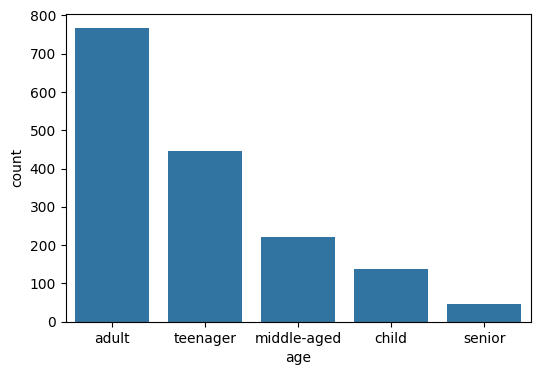

In [165]:
plt.figure(figsize=(6, 4))
sns.countplot(x='age', data=bias_data, order=bias_data['age'].value_counts().index)
#plt.title('HAA500-B Class Distribution (Age)')
plt.show()

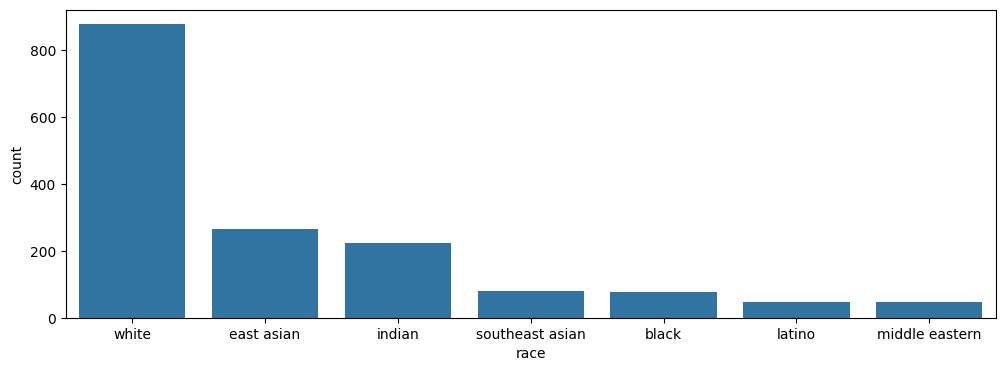

In [166]:
plt.figure(figsize=(12, 4))
sns.countplot(x='race', data=bias_data, order=bias_data['race'].value_counts().index)
#plt.title('HAA500-B Class Distribution (Race)')
plt.show()

In [167]:
def PlotAgeDistribution(data):
    contingency_table = pd.crosstab(data['action'], data['age'])

    # chi square
    chi2, _, _, _ = chi2_contingency(contingency_table)

    # plot
    contingency_table.plot(kind='bar', figsize=(30, 10),  stacked=True, title='Age Class Distribution Visualization')

    # y
    plt.ylabel('count')
    plt.ylim(top=25)

    # x
    plt.xlabel('Action')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

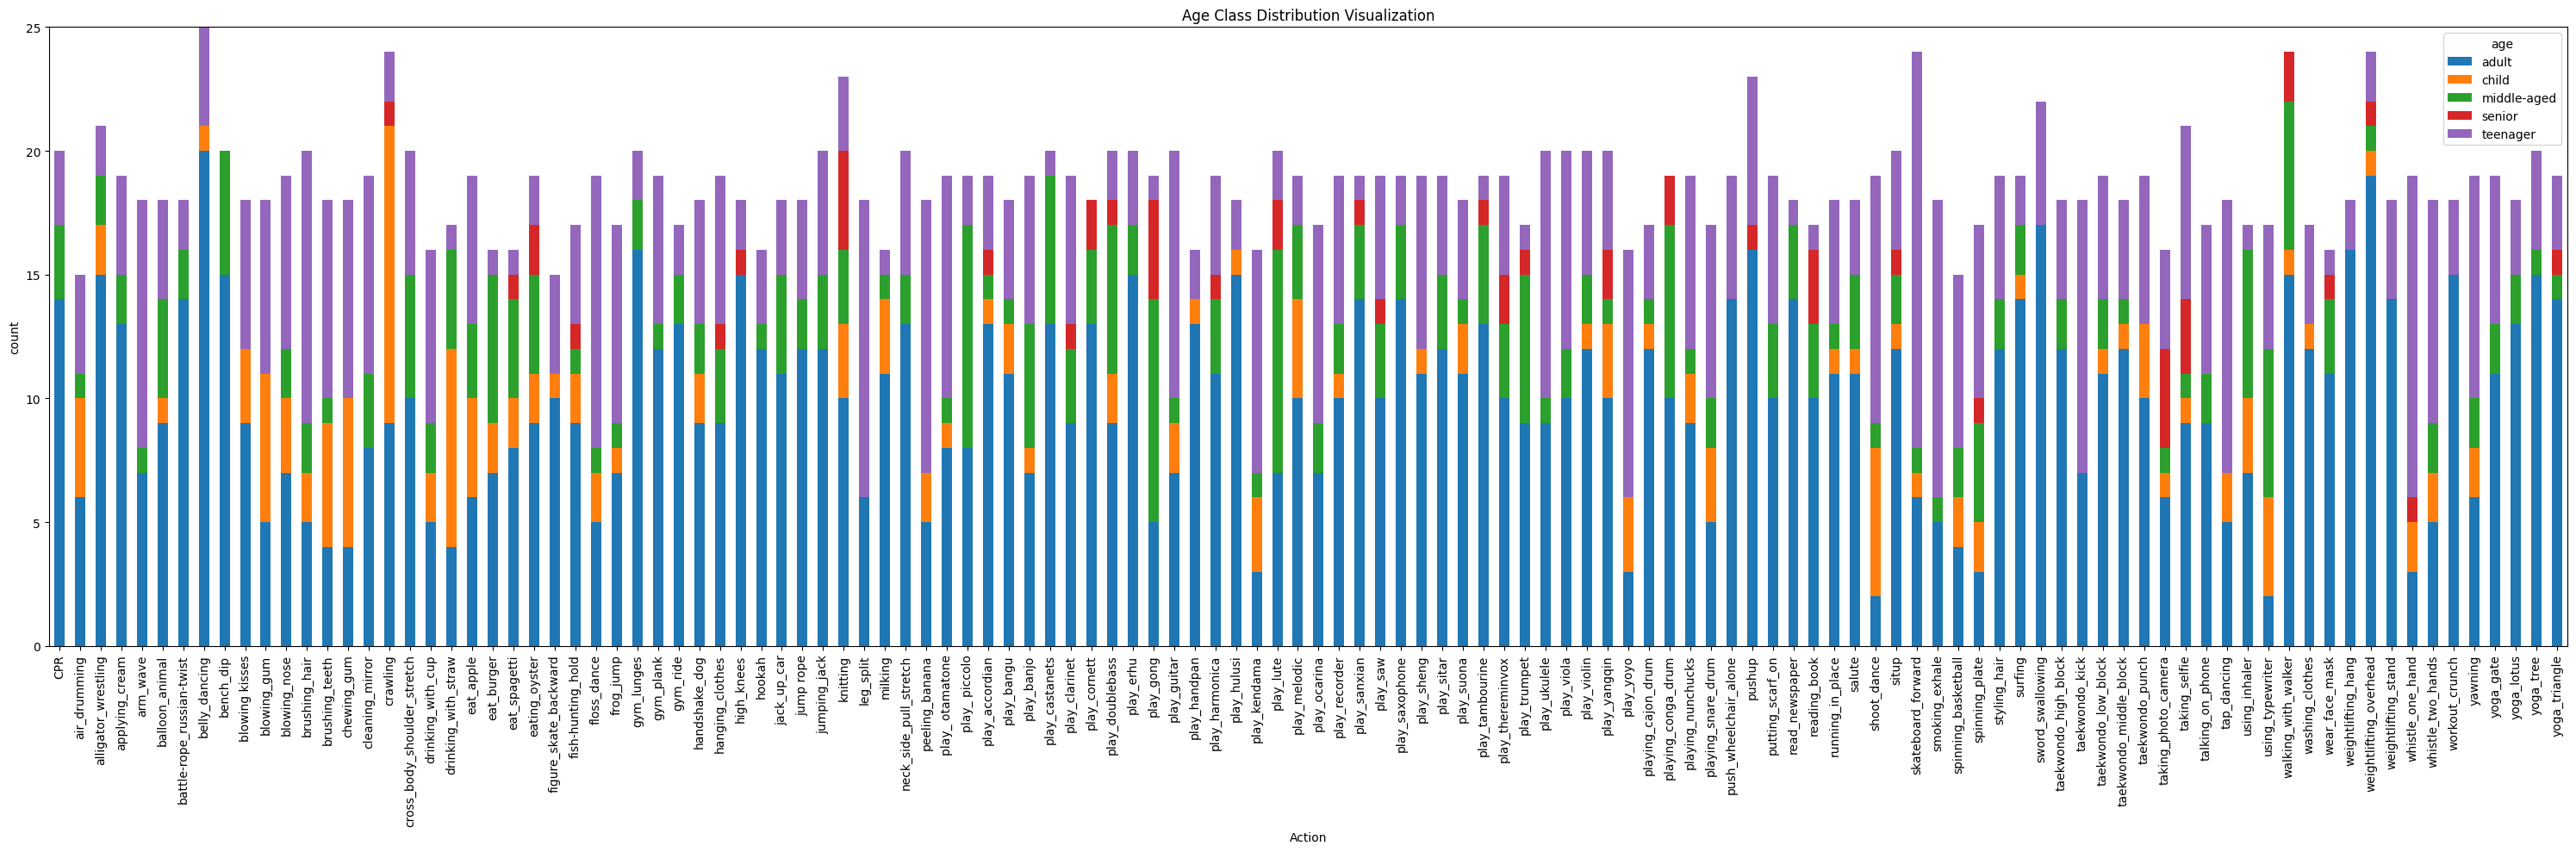

In [168]:
bias_data_copy =  bias_data_copy[bias_data_copy['action'].isin(bias_data['action'])]
PlotAgeDistribution(bias_data_copy)

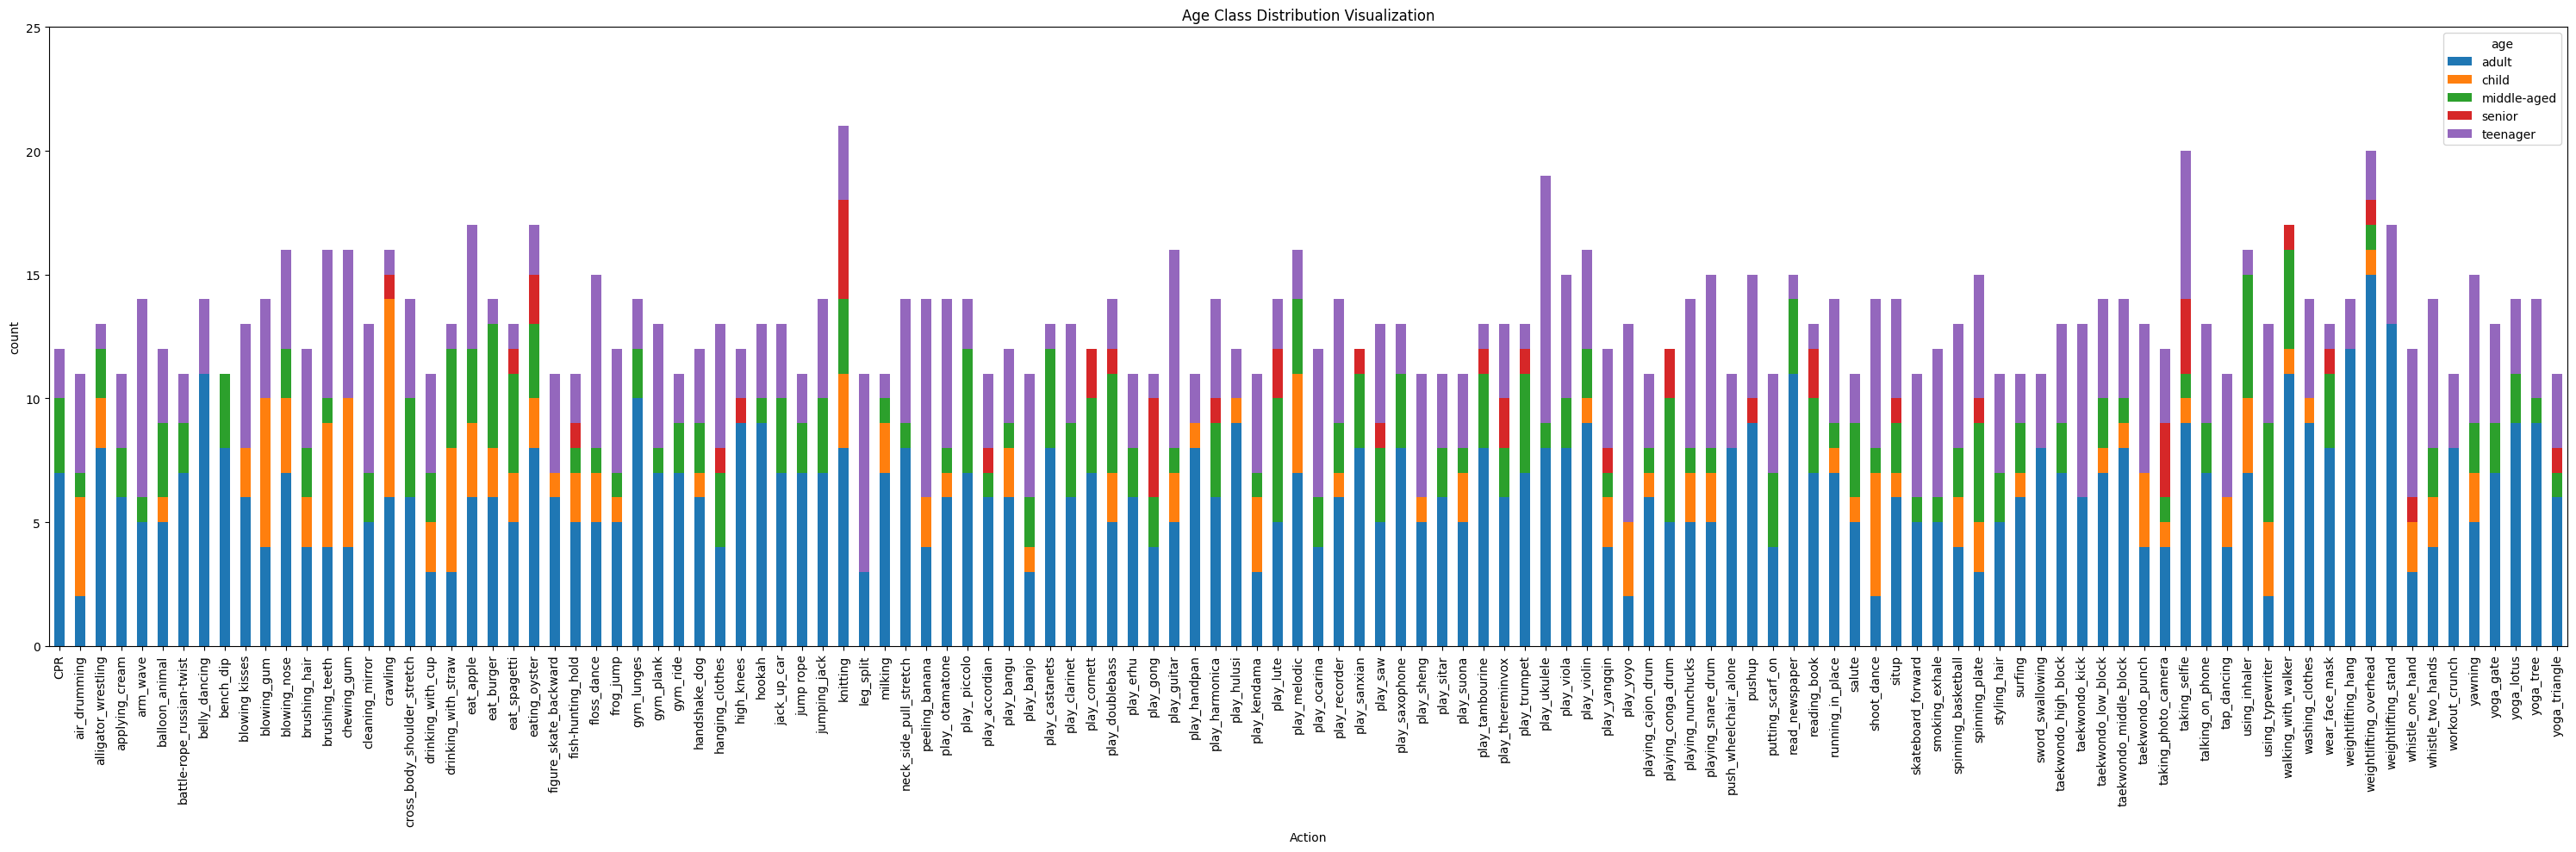

In [169]:
PlotAgeDistribution(bias_data)

In [170]:
def PlotIR(data, bias_category):
    actions = data['action'].unique()
    IR_data = []
    for action in actions:
        action_data = data[data['action'] == action][bias_category]
        counts = action_data.value_counts()
        IR = counts.max() / counts.min()
        IR_data.append({'action': action, 'IR': IR})

    IR_df = pd.DataFrame(IR_data)
    average = IR_df['IR'].mean()

    # aux
    plt.figure(figsize=(30, 10))
    plt.bar(IR_df['action'], IR_df['IR'])
    plt.title('Age IR Visualization')
    plt.tight_layout()

    # y
    plt.ylabel('Age IR Score')
    plt.ylim(top=30)

    # x
    plt.xlabel('Actions')
    plt.xticks(rotation=90)
    plt.axhline(y=average, color = 'r', linestyle = '--', label = 'Average IR Score')

    # show
    plt.legend()
    plt.show()

    print("Average IR Score: " + str(average))

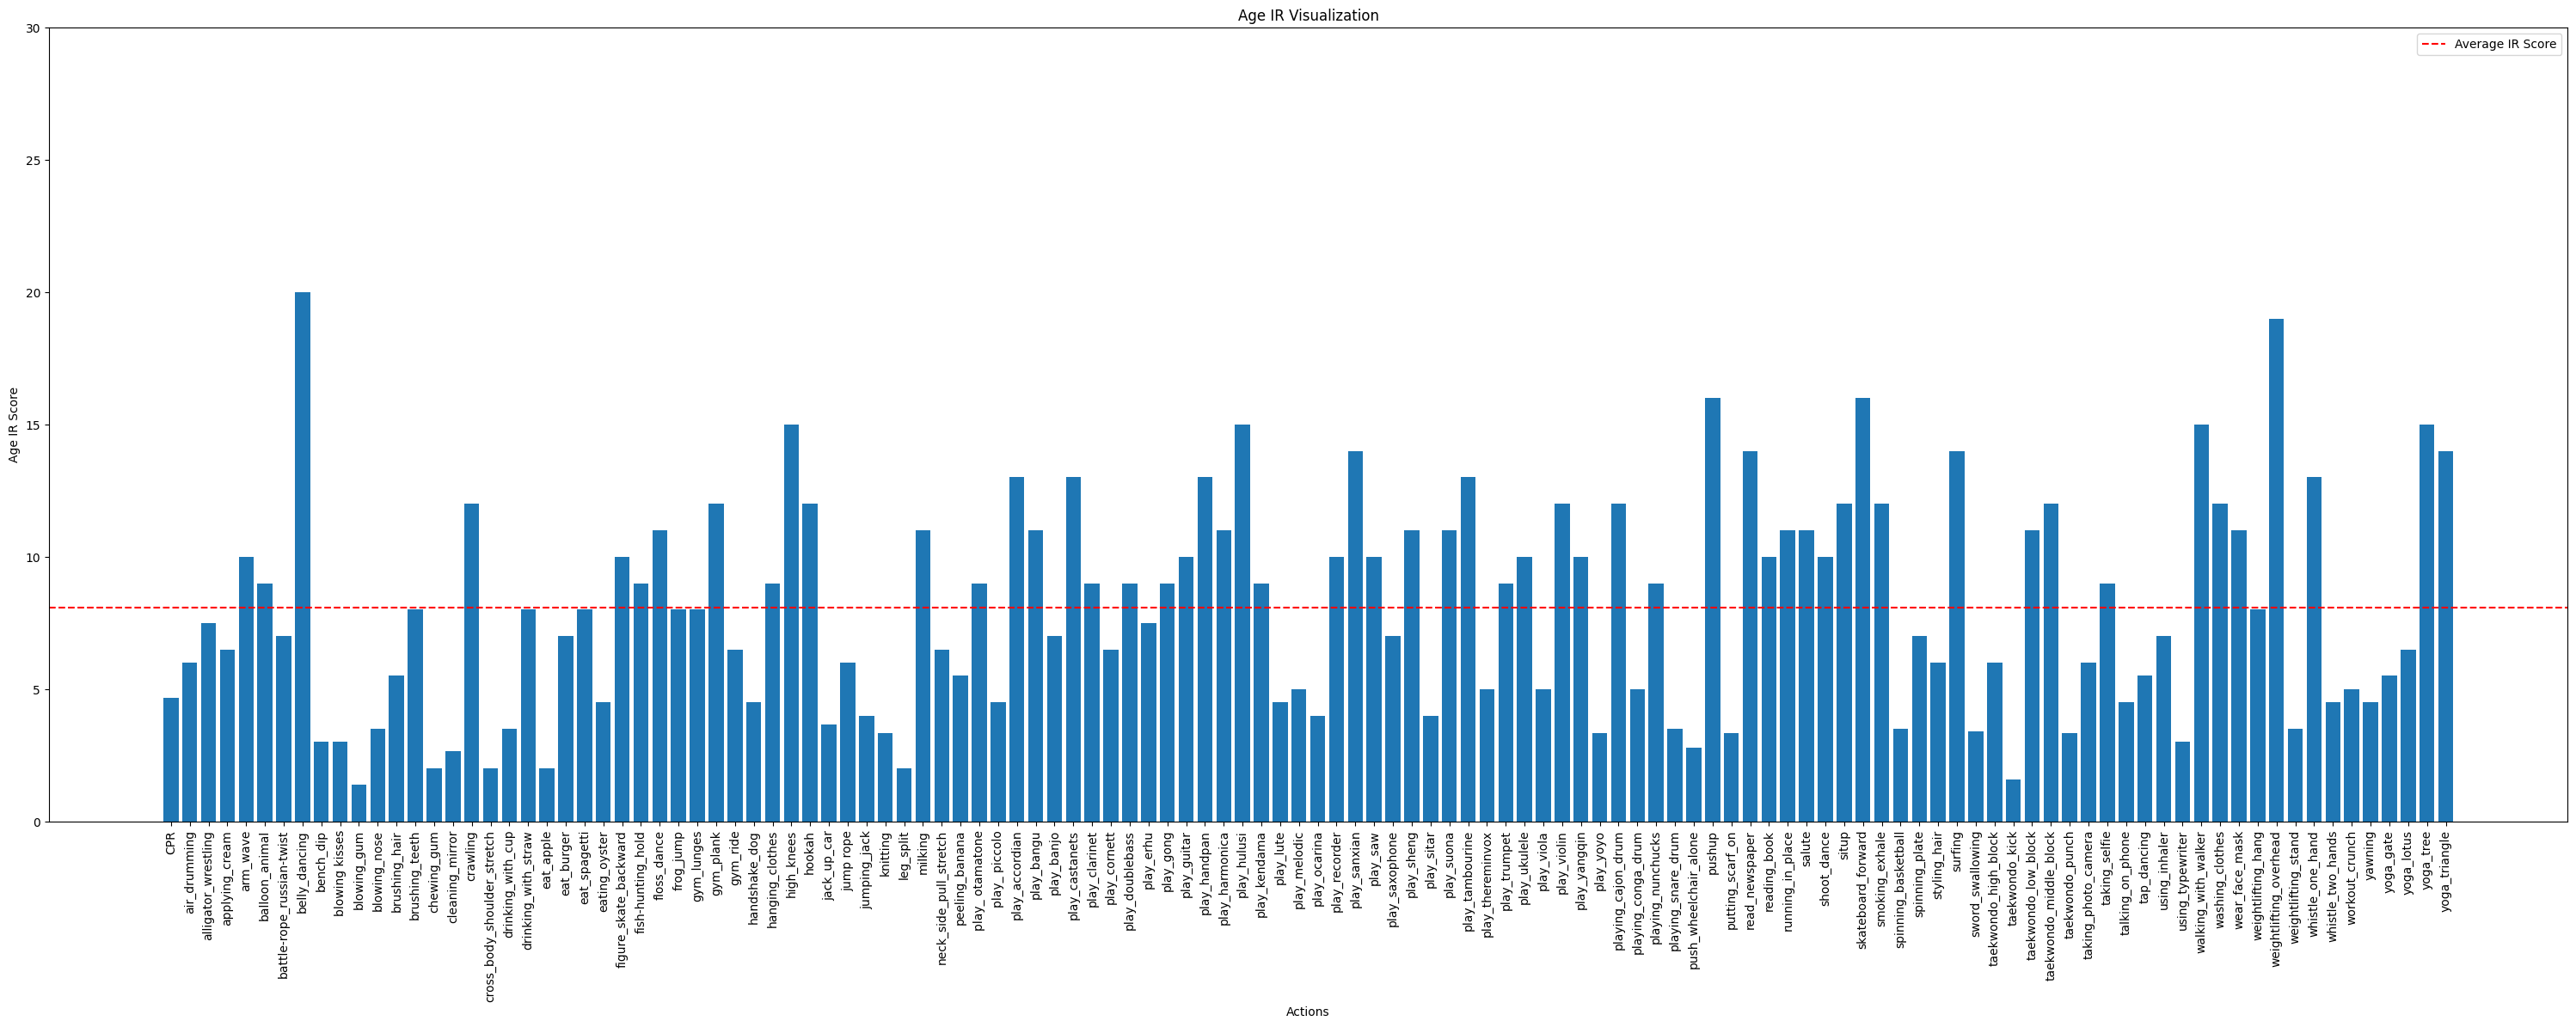

Average IR Score: 8.073809523809524


In [171]:
PlotIR(bias_data_copy, 'age')

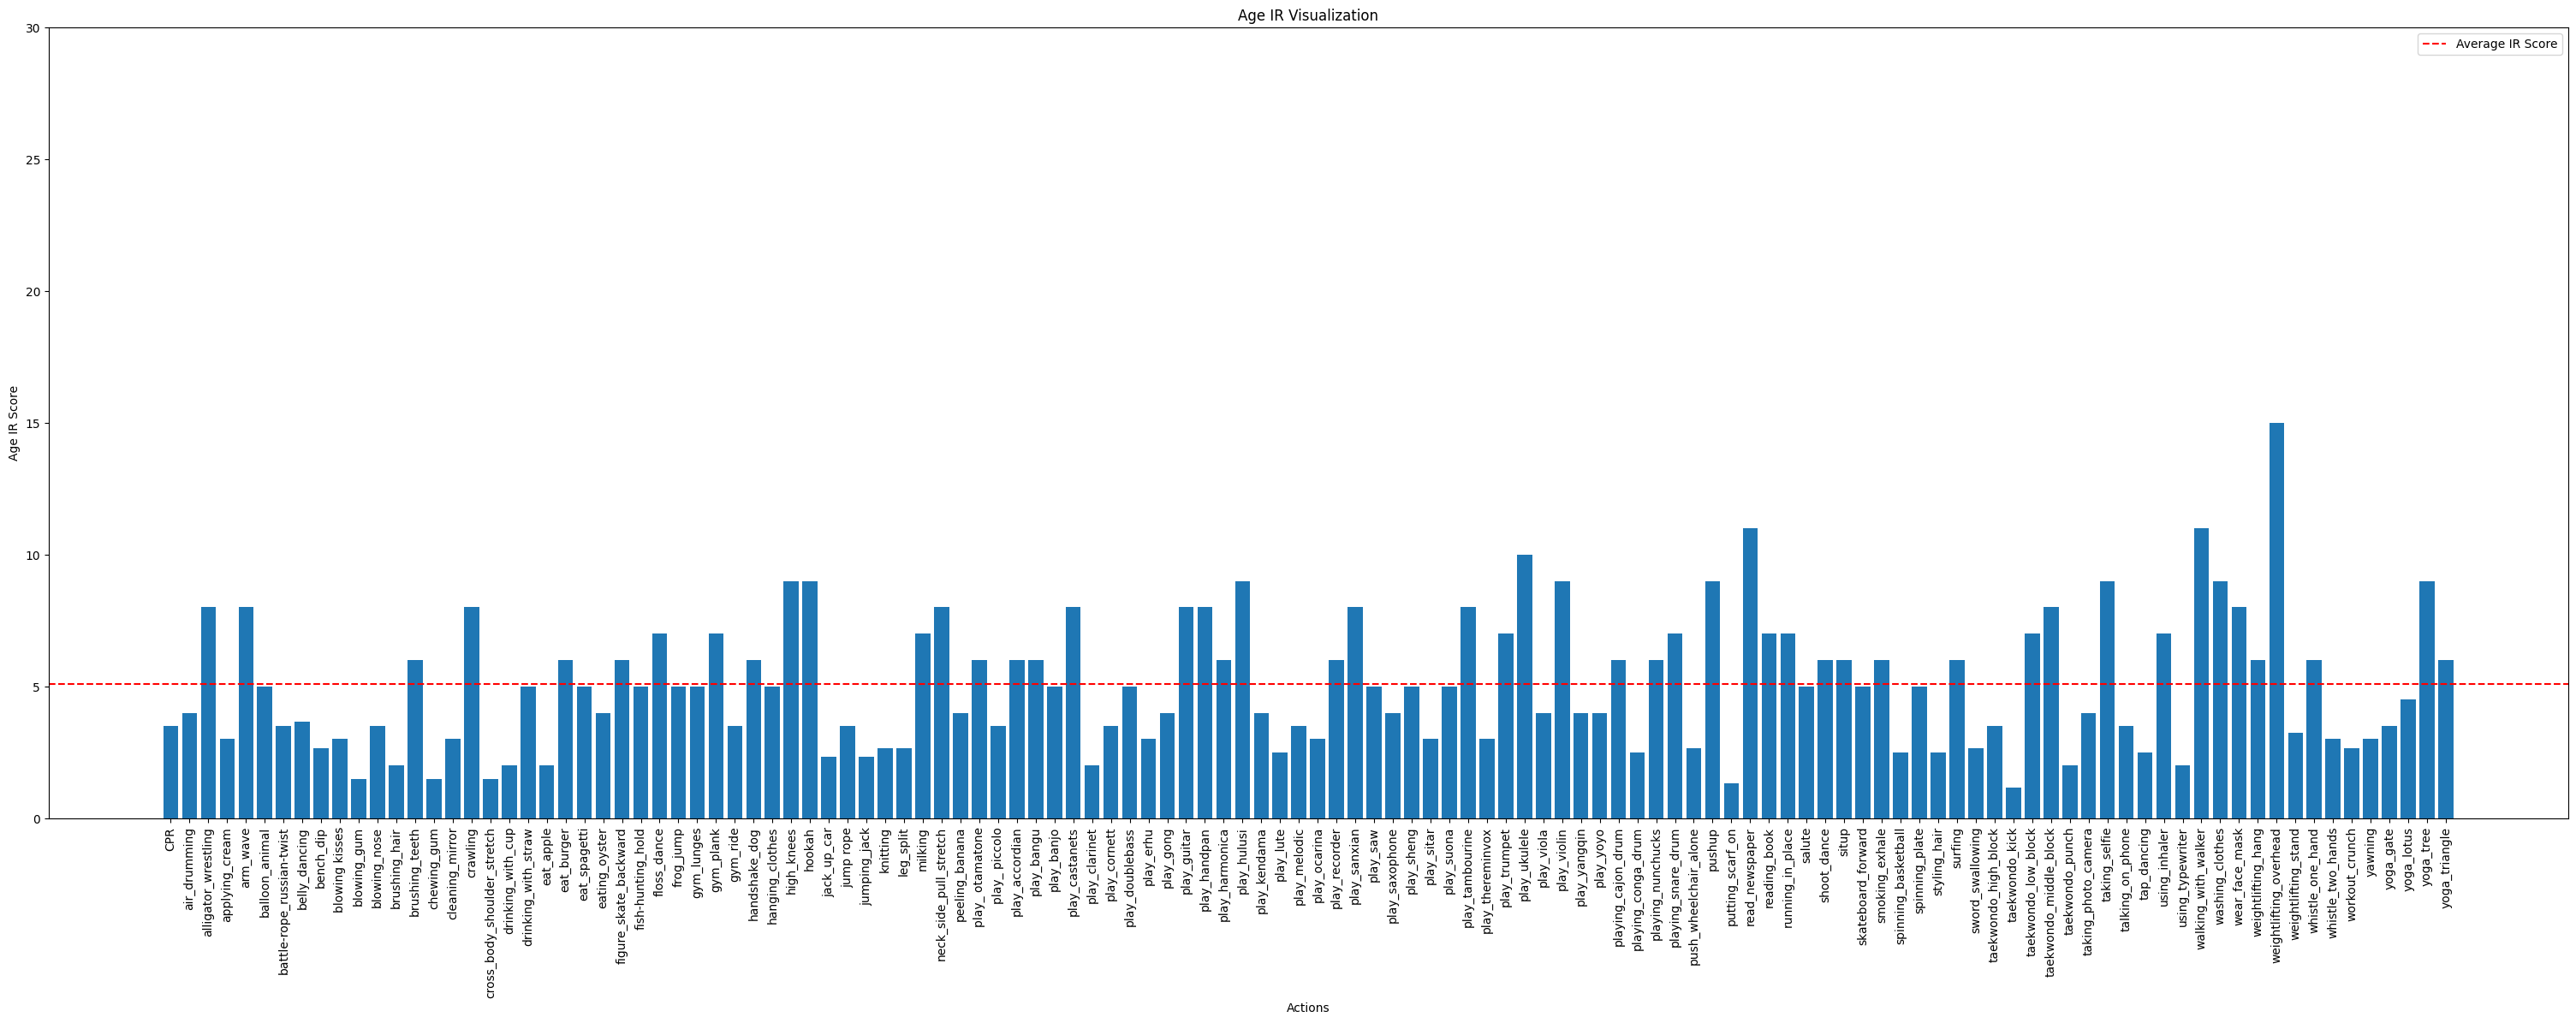

Average IR Score: 5.099043715846995


In [172]:
PlotIR(bias_data, 'age')

In [173]:
def PlotChi2(data, bias_category):
    actions = data['action'].unique()
    chi2_data = []
    for action in actions:
        action_data = data[data['action'] == action][bias_category]
        other_data = data[data['action'] != action][bias_category]

        # create table
        observed = pd.crosstab(pd.Series(['action'] * len(action_data) + ['other'] * len(other_data)),
                               pd.Series(action_data.tolist() + other_data.tolist())
        )

        # calculate chi2
        chi2, _, _, _ = chi2_contingency(observed)
        chi2_data.append({'action': action, 'chi2': chi2})

    chi2_df = pd.DataFrame(chi2_data)
    average = chi2_df['chi2'].mean()

    # aux
    plt.figure(figsize=(30, 10))
    plt.bar(chi2_df['action'], chi2_df['chi2'])
    plt.title('Age Chi-Square Visualization')
    plt.tight_layout()

    # y
    plt.ylabel('Age Chi-Square Score')
    plt.ylim(top=90)

    # x
    plt.xlabel('Actions')
    plt.xticks(rotation=90)
    plt.axhline(y=average, color = 'r', linestyle = '--', label = 'Average Chi-Square Score')

    # show
    plt.legend()
    plt.show()

    print("Average Chi-Square Score: " + str(average))

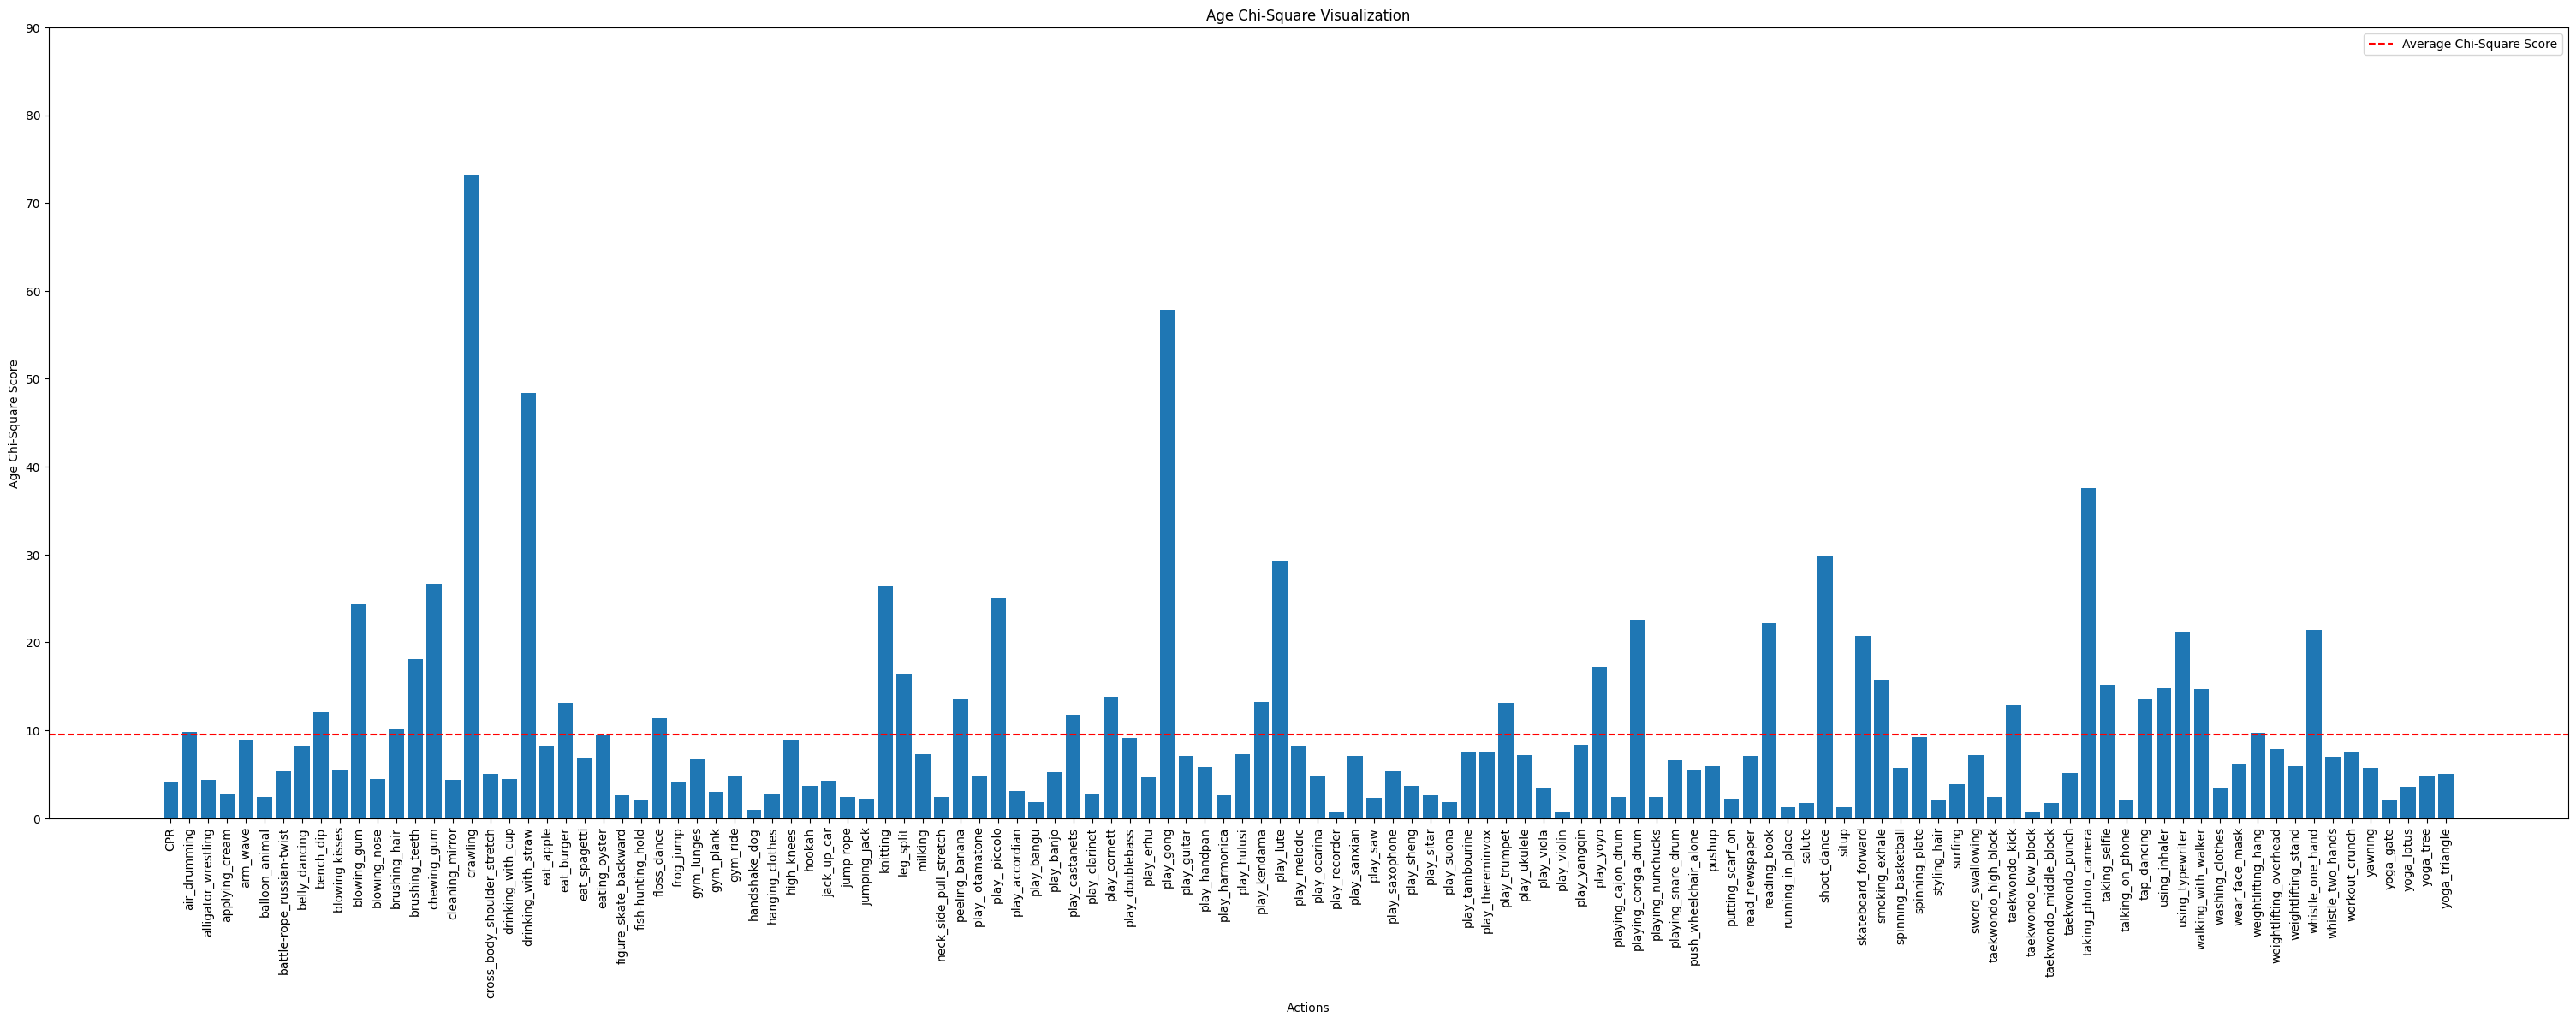

Average Chi-Square Score: 9.518231631346817


In [174]:
PlotChi2(bias_data_copy, 'age')

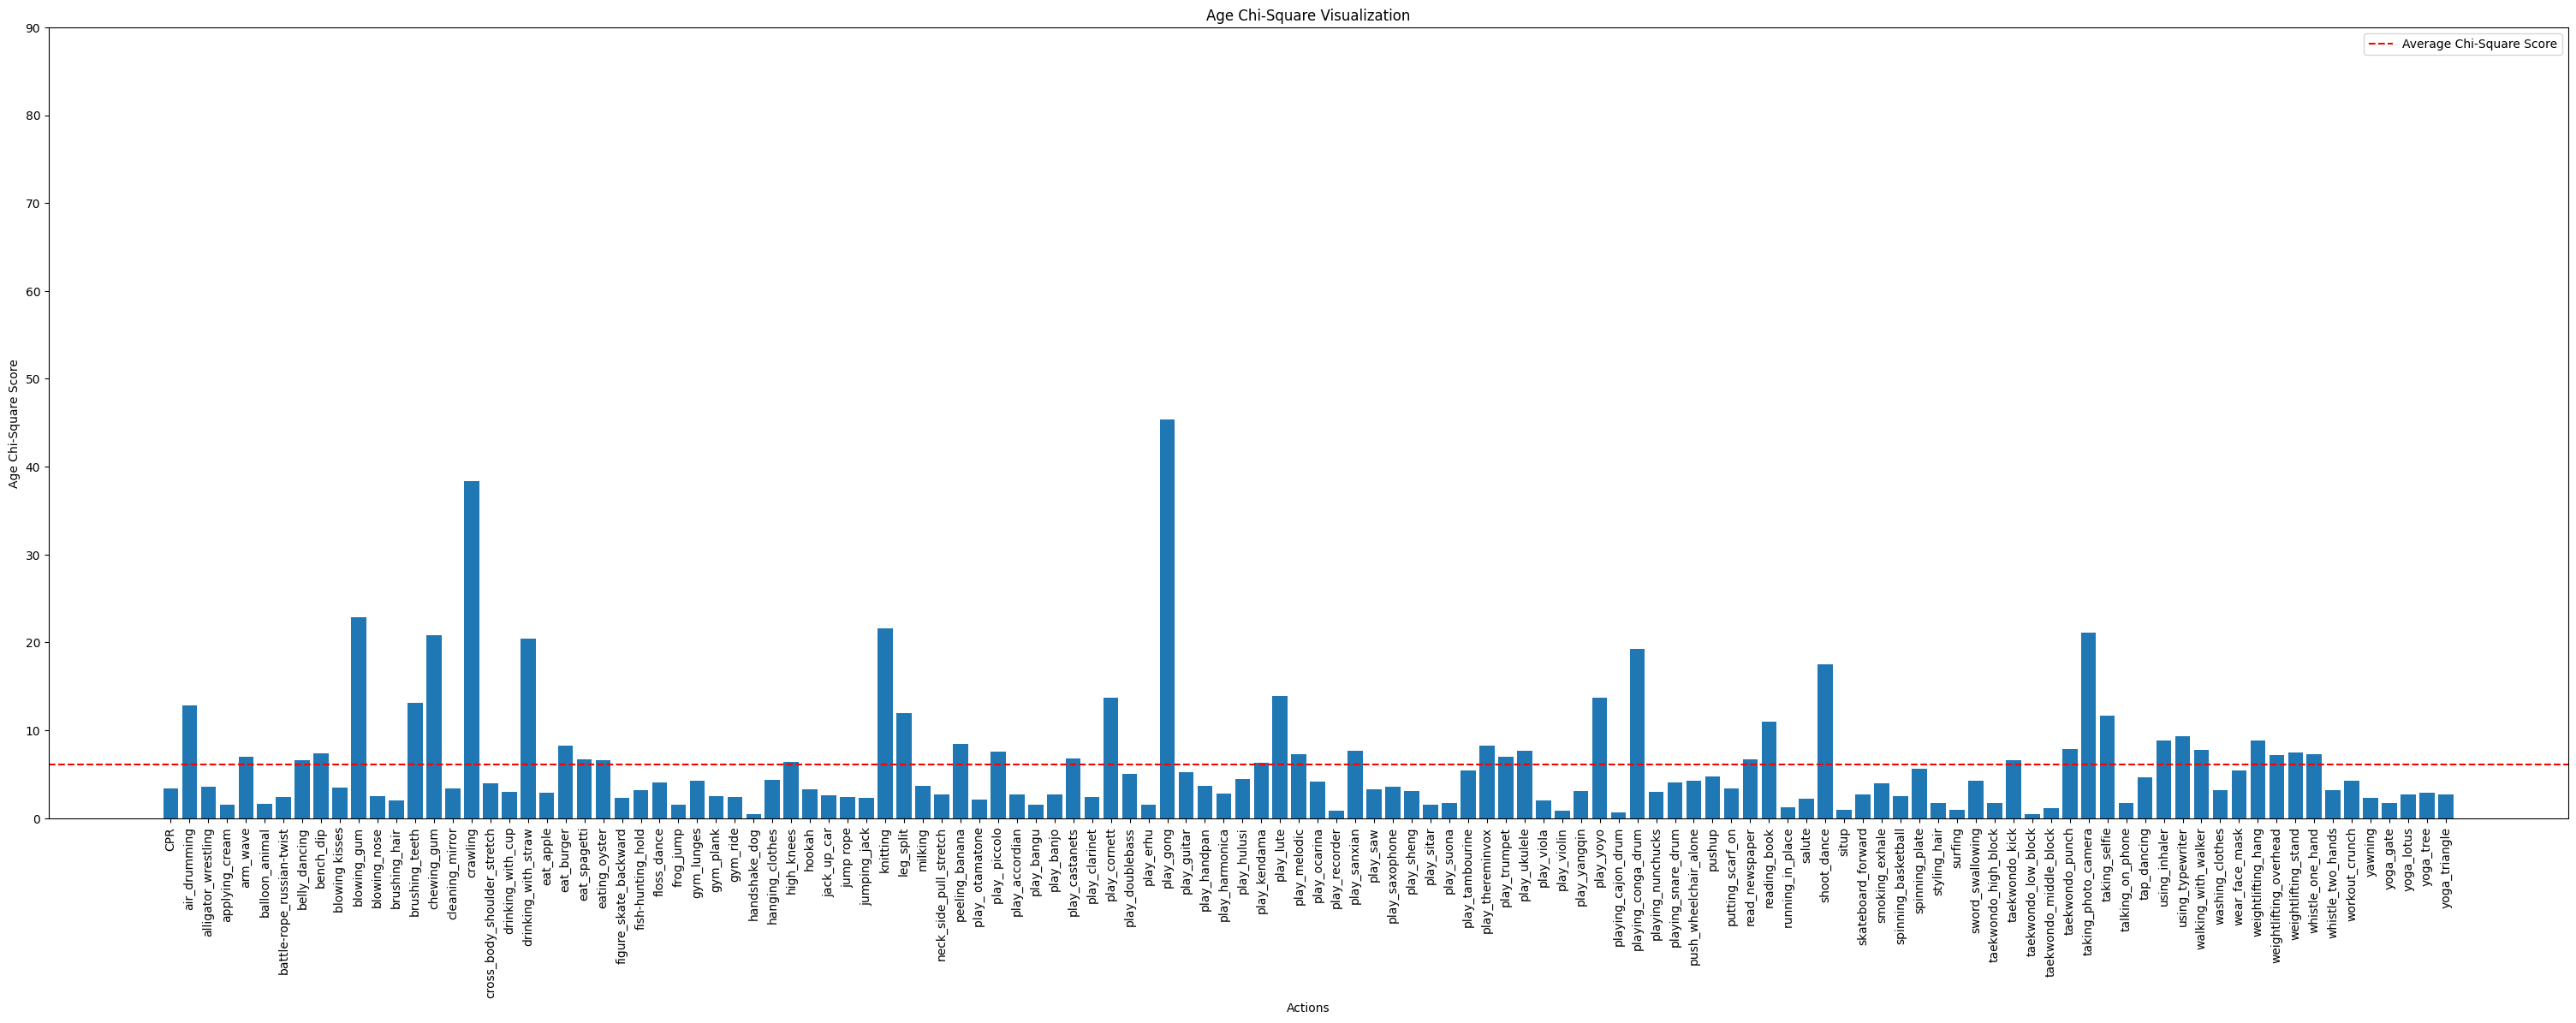

Average Chi-Square Score: 6.1232805661151595


In [175]:
PlotChi2(bias_data, 'age')

# Experimental Results

In [176]:
def GetScores(data, bias_category, truth, pred):
    scores = (data.groupby(bias_category)
              .apply(lambda bias_level: [(bias_level[truth] == bias_level[pred]).mean(),
                                          f1_score(bias_level[truth], bias_level[pred], average = 'macro', zero_division = 0),
                                          len(bias_level)], include_groups=False))
    formatted = []

    for bias_level in ['none', 'small', 'medium', 'large']:
        formatted.append({'bias_category': bias_category, 'bias_level': bias_level, 'acc': scores[bias_level][0], 'f1': scores[bias_level][1], 'count': scores[bias_level][2]})

    formatted = pd.DataFrame(formatted)

    all_count = formatted['count'].sum()
    all = {'bias_category': bias_category,
            'bias_level': 'all',
            'acc': formatted['acc'].mul(formatted['count']).sum() / all_count,
            'f1': formatted['f1'].mul(formatted['count']).sum() / all_count,
            'count': all_count}

    formatted.loc[len(formatted)] = all

    return formatted

def EvalData(truth, pred, action_data):
    # merge data
    data = pd.merge(truth, pred, on = ['imgPath', 'action'], suffixes = ('_truth', '_pred'))
    data = pd.merge(data, action_data, on = 'action', how = 'left')

    # score data
    scores = []

    # bias data
    bias_categorys = ['gender_bias', 'age_bias', 'race_bias']
    bias_levels = ['none', 'small', 'medium', 'large', 'all']

    # goes -> category -> level and finds the accuracy and f1 scores
    gender_scores = GetScores(data, 'gender_bias', 'gender_truth', 'gender_pred')
    age_scores = GetScores(data, 'age_bias', 'age_truth', 'age_pred')
    race_scores = GetScores(data, 'race_bias', 'race_truth', 'race_pred')

    scores = pd.concat([gender_scores, age_scores, race_scores], axis=0, ignore_index=True)

    all_count = scores['count'].sum()
    all = {'bias_category': 'all',
            'bias_level': 'all',
            'acc': scores['acc'].mul(scores['count']).sum() / all_count,
            'f1': scores['f1'].mul(scores['count']).sum() / all_count,
            'count': all_count}

    scores.loc[len(scores)] = all

    return scores

## Main Experiment

In [177]:
video_llava = pd.read_csv("/content/drive/MyDrive/results/video/prompt6/video_llava_output.csv")
llava_next_video = pd.read_csv("/content/drive/MyDrive/results/video/prompt6/llava_next_video_output.csv")
one_vision = pd.read_csv("/content/drive/MyDrive/results/video/prompt6/one_vision_output.csv")
qwen2_vl = pd.read_csv("/content/drive/MyDrive/results/video/prompt6/qwen2_vl_output.csv")
qwen2_5_vl = pd.read_csv("/content/drive/MyDrive/results/video/prompt6/qwen2_5_vl_output.csv")

In [178]:
video_llava_results = EvalData(bias_data, video_llava, action_data)
EvalData(bias_data, video_llava, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.966667,0.646923,90
1,gender_bias,small,0.951754,0.635743,1140
2,gender_bias,medium,0.917722,0.612667,316
3,gender_bias,large,0.900000,0.898990,70
4,gender_bias,all,0.943688,0.643256,1616
5,age_bias,none,0.454545,0.320841,176
6,age_bias,small,0.445386,0.327846,1062
7,age_bias,medium,0.500000,0.490191,218
8,age_bias,large,0.393750,0.310337,160
9,age_bias,all,0.448639,0.347250,1616


In [179]:
llava_next_video_results = EvalData(bias_data, llava_next_video, action_data)
EvalData(bias_data, llava_next_video, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.933333,0.636845,90
1,gender_bias,small,0.949123,0.641543,1140
2,gender_bias,medium,0.939873,0.635857,316
3,gender_bias,large,0.957143,0.957064,70
4,gender_bias,all,0.946782,0.653837,1616
5,age_bias,none,0.573864,0.315407,176
6,age_bias,small,0.608286,0.331229,1062
7,age_bias,medium,0.573394,0.350734,218
8,age_bias,large,0.631250,0.439002,160
9,age_bias,all,0.602104,0.342808,1616


In [180]:
one_vision_results = EvalData(bias_data, one_vision, action_data)
EvalData(bias_data, one_vision, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.944444,0.641285,90
1,gender_bias,small,0.904386,0.625990,1140
2,gender_bias,medium,0.917722,0.629873,316
3,gender_bias,large,0.885714,0.616915,70
4,gender_bias,all,0.908416,0.627208,1616
5,age_bias,none,0.630682,0.520093,176
6,age_bias,small,0.670433,0.567648,1062
7,age_bias,medium,0.637615,0.459593,218
8,age_bias,large,0.706250,0.496880,160
9,age_bias,all,0.665223,0.540885,1616


In [181]:
qwen2_vl_results = EvalData(bias_data, qwen2_vl, action_data)
EvalData(bias_data, qwen2_vl, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.611111,0.349511,90
1,gender_bias,small,0.471930,0.190271,1140
2,gender_bias,medium,0.436709,0.195328,316
3,gender_bias,large,0.400000,0.172712,70
4,gender_bias,all,0.469678,0.199368,1616
5,age_bias,none,0.369318,0.117659,176
6,age_bias,small,0.394539,0.109001,1062
7,age_bias,medium,0.334862,0.113209,218
8,age_bias,large,0.425000,0.120344,160
9,age_bias,all,0.386757,0.111635,1616


In [182]:
qwen2_5_vl_results = EvalData(bias_data, qwen2_5_vl, action_data)
EvalData(bias_data, qwen2_5_vl, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.955556,0.954453,90
1,gender_bias,small,0.950877,0.633399,1140
2,gender_bias,medium,0.936709,0.625439,316
3,gender_bias,large,0.942857,0.942857,70
4,gender_bias,all,0.948020,0.663128,1616
5,age_bias,none,0.625000,0.497526,176
6,age_bias,small,0.585687,0.415107,1062
7,age_bias,medium,0.568807,0.566641,218
8,age_bias,large,0.625000,0.591072,160
9,age_bias,all,0.591584,0.461948,1616


In [183]:
data = [video_llava_results, llava_next_video_results, one_vision_results, qwen2_vl_results, qwen2_5_vl_results]

## Ablation: Number of Frames

In [184]:
def Format(data):
    return data.iloc[:-1]['acc'].tolist()

def CreateRadar(data, title):
    # create plot
    fig = go.Figure()

    # accuracy data
    data0 = Format(data[0])
    data1 = Format(data[1])
    data2 = Format(data[2])
    data3 = Format(data[3])
    data4 = Format(data[4])

    # missing last data point to connect
    data0 += data0[:1]
    data1 += data1[:1]
    data2 += data2[:1]
    data3 += data3[:1]
    data4 += data4[:1]

    data = [data0, data1, data2, data3, data4]

    # metrics have to copy last one so they meet
    bias_cat_lvl = ['Gender (None)', 'Gender (Small)', 'Gender (Medium)', 'Gender (Large)', 'Gender (All)',
                    'Age (None)', 'Age (Small)', 'Age (Medium)', 'Age (Large)', 'Age (All)',
                    'Race (None)', 'Race (Small)', 'Race (Medium)', 'Race (Large)', 'Race (All)', 'Gender (None)']

    # models
    models = ['Video-LLaVA', 'LLaVA-Next-Video', 'LLaVA-OneVision', 'Qwen2-VL', 'Qwen2.5-VL']

    # add data
    for i in range(0, 5):
        fig.add_trace(go.Scatterpolar(name = models[i], r = data[i], theta = bias_cat_lvl, fill = 'toself'))

    # set color and opacity for lines
    fig.data[0].update(line = dict(color = 'rgba(255, 0, 0, 1)'))
    fig.data[1].update(line = dict(color = 'rgba(0, 255, 0, 1)'))
    fig.data[2].update(line = dict(color = 'rgba(0, 0, 255, 1)'))
    fig.data[3].update(line = dict(color = 'rgba(128, 0, 128, 1)'))
    fig.data[4].update(line = dict(color = 'rgba(255, 165, 0, 1)'))

    # set color and opacity for fill
    fig.data[0].update(fillcolor = 'rgba(255, 0, 0, .2)')
    fig.data[1].update(fillcolor = 'rgba(0, 255, 0, .2)')
    fig.data[2].update(fillcolor = 'rgba(0, 0, 255, .2)')
    fig.data[3].update(fillcolor = 'rgba(128, 0, 128, .2)')
    fig.data[4].update(fillcolor = 'rgba(255, 165, 0, .2)')

    # set markers to be same as lines
    fig.update_traces(line = dict(width = 2),marker = dict(size = 2))

    # make ticks 20%
    fig.update_layout(polar = dict(radialaxis = dict(showline=False, tickvals = [0, .2, .4, .6, .8, 1])))

    # show
    fig.show()

In [185]:
CreateRadar(data, 'Performance on HAA500-B Benchmark')

In [186]:
frames_2 = pd.read_csv("/content/drive/MyDrive/results/video/ablation/prompt6/quant4/frames2/one_vision_output.csv")
frames_4 = pd.read_csv("/content/drive/MyDrive/results/video/ablation/prompt6/quant4/frames4/one_vision_output.csv")
frames_6 = pd.read_csv("/content/drive/MyDrive/results/video/ablation/prompt6/quant4/frames6/one_vision_output.csv")
frames_8 = pd.read_csv("/content/drive/MyDrive/results/video/ablation/prompt6/quant4/frames8/one_vision_output.csv")

In [187]:
EvalData(bias_data, frames_2, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.733333,0.545141,90
1,gender_bias,small,0.704386,0.542025,1140
2,gender_bias,medium,0.623418,0.504535,316
3,gender_bias,large,0.500000,0.427834,70
4,gender_bias,all,0.681312,0.529921,1616
5,age_bias,none,0.477273,0.429423,176
6,age_bias,small,0.489642,0.498321,1062
7,age_bias,medium,0.440367,0.359287,218
8,age_bias,large,0.531250,0.469407,160
9,age_bias,all,0.485767,0.469199,1616


In [188]:
EvalData(bias_data, frames_4, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.866667,0.611862,90
1,gender_bias,small,0.810526,0.592034,1140
2,gender_bias,medium,0.803797,0.587127,316
3,gender_bias,large,0.742857,0.556503,70
4,gender_bias,all,0.809406,0.590640,1616
5,age_bias,none,0.556818,0.490186,176
6,age_bias,small,0.574388,0.522997,1062
7,age_bias,medium,0.532110,0.411522,218
8,age_bias,large,0.625000,0.482841,160
9,age_bias,all,0.571782,0.500410,1616


In [189]:
EvalData(bias_data, frames_6, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.933333,0.636845,90
1,gender_bias,small,0.906140,0.626062,1140
2,gender_bias,medium,0.911392,0.628350,316
3,gender_bias,large,0.842857,0.595960,70
4,gender_bias,all,0.905941,0.625806,1616
5,age_bias,none,0.625000,0.511052,176
6,age_bias,small,0.664783,0.561603,1062
7,age_bias,medium,0.614679,0.443694,218
8,age_bias,large,0.725000,0.519482,160
9,age_bias,all,0.659653,0.536021,1616


In [190]:
EvalData(bias_data, frames_8, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.944444,0.641285,90
1,gender_bias,small,0.904386,0.625990,1140
2,gender_bias,medium,0.917722,0.629873,316
3,gender_bias,large,0.885714,0.616915,70
4,gender_bias,all,0.908416,0.627208,1616
5,age_bias,none,0.630682,0.520093,176
6,age_bias,small,0.670433,0.567648,1062
7,age_bias,medium,0.637615,0.459593,218
8,age_bias,large,0.706250,0.496880,160
9,age_bias,all,0.665223,0.540885,1616


## Ablation: Quantization

In [191]:
quant8 = pd.read_csv("/content/drive/MyDrive/results/video/ablation/prompt6/quant8/frames8/one_vision_output.csv")

In [192]:
EvalData(bias_data, one_vision, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.944444,0.641285,90
1,gender_bias,small,0.904386,0.625990,1140
2,gender_bias,medium,0.917722,0.629873,316
3,gender_bias,large,0.885714,0.616915,70
4,gender_bias,all,0.908416,0.627208,1616
5,age_bias,none,0.630682,0.520093,176
6,age_bias,small,0.670433,0.567648,1062
7,age_bias,medium,0.637615,0.459593,218
8,age_bias,large,0.706250,0.496880,160
9,age_bias,all,0.665223,0.540885,1616


In [193]:
EvalData(bias_data, quant8, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.977778,0.977376,90
1,gender_bias,small,0.967544,0.647352,1140
2,gender_bias,medium,0.968354,0.648782,316
3,gender_bias,large,0.957143,0.957134,70
4,gender_bias,all,0.967822,0.679431,1616
5,age_bias,none,0.721591,0.599813,176
6,age_bias,small,0.715631,0.587828,1062
7,age_bias,medium,0.678899,0.582206,218
8,age_bias,large,0.743750,0.510958,160
9,age_bias,all,0.714109,0.580764,1616
